In [1]:
import pandas as pd
import numpy as np
import glob
import os
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.cluster import AgglomerativeClustering
import matplotlib.font_manager as fm
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Set path to your CSV files
csv_dir = "/content/drive/MyDrive/Dublin/30sec/Analysis/video_complixity/*.csv"  # 8K60FPS_Link is a shortcut folder to the VEDIA dataset

# Get sorted list of CSV files
all_files = sorted(glob.glob(csv_dir))

# Initialize list to store DataFrames
dfs = []

for file in all_files:
    try:
        if 'vmaf' in file:
            continue
        # Extract video number from filename (assuming format: 000_videoname.csv)
        filename = os.path.basename(file)
        video_number = int(filename.split('_')[0])  # First part is numeric

        # Read CSV and add video number column
        df = pd.read_csv(file)
        df['video_number'] = video_number
        df['video_id'] = f"{video_number:03d}_30s"


        dfs.append(df)

    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# Concatenate all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Optional: Verify results
print(f"Combined DataFrame shape: {combined_df.shape}")
print("Number of unique videos:", len(combined_df['video_number'].unique()))

Combined DataFrame shape: (72000, 23)
Number of unique videos: 40


In [4]:
# viewing loaded data
combined_df.head(10)

,Frame,SI,TI,Contrast,Brightness,Sharpness,Blockiness,TextureComplexity,ColorVar_U,ColorVar_V,...,Entropy,EntropyDiff,MotionIntensityDiff,EdgeDirectionality,AvgMotionXAxis,AvgMotionYAxis,StdMotionXAxis,StdMotionYAxis,video_number,video_id
0,0,114.8064,0.0000,149.125,0.4470,330.75,183.25,0.2509,275.00,275.25,...,7.1614,0.0000,0.0000,4.1330,0.0000,0.0000,0.0000,0.0000,40,040_30s
1,1,115.2771,8.9141,149.125,0.4469,335.00,183.25,0.2526,275.00,275.25,...,7.1616,0.0002,5.0156,4.1330,-0.0467,0.1389,0.2722,0.1642,40,040_30s
2,2,115.1109,8.2344,149.125,0.4469,333.25,183.25,0.2521,275.00,275.50,...,7.1615,0.0001,4.5742,4.1331,0.0207,0.1156,0.2664,0.1675,40,040_30s
3,3,114.7246,10.1562,149.250,0.4469,329.25,183.25,0.2504,275.50,275.25,...,7.1621,0.0007,5.6133,4.1330,-0.0652,0.1109,0.2852,0.2057,40,040_30s
4,4,114.8729,12.0859,149.375,0.4468,330.75,183.25,0.2513,275.00,275.00,...,7.1623,0.0002,6.6992,4.1330,-0.0795,0.1770,0.2959,0.1941,40,040_30s
5,5,114.8200,11.4062,149.375,0.4468,330.25,183.25,0.2505,275.00,275.00,...,7.1625,0.0001,6.3828,4.1330,0.0970,0.1842,0.3013,0.1925,40,040_30s
6,6,114.9651,12.2109,149.500,0.4468,331.00,183.25,0.2517,276.00,275.75,...,7.1635,0.0010,6.7812,4.1331,0.2367,0.1411,0.2654,0.1848,40,040_30s
7,7,115.2816,8.9844,149.625,0.4466,333.50,183.25,0.2522,276.00,275.75,...,7.1640,0.0005,5.1328,4.1331,0.0786,0.1118,0.2917,0.1982,40,040_30s
8,8,115.2608,8.4531,149.625,0.4466,333.50,183.25,0.2524,275.75,276.50,...,7.1640,0.0000,4.7930,4.1331,-0.0075,0.0765,0.2659,0.1980,40,040_30s
9,9,114.9693,8.7578,149.750,0.4466,331.00,183.25,0.2513,276.25,276.00,...,7.1644,0.0005,4.9844,4.1332,0.0746,0.0579,0.3005,0.2194,40,040_30s


In [5]:
# Custom aggregation functions
def linear_trend(s):
    x = np.arange(len(s))
    return np.polyfit(x, s, 1)[0] if len(s) > 1 else np.nan

def entropy(s):
    return skew(s) * kurtosis(s)  # Custom complexity measure

# Define the columns you want to keep

columns_to_use = [
 'SI',
 'TI',
 'TextureComplexity',
 'Colorfulness',
 'Entropy',
 'AvgMotionXAxis',
 'AvgMotionYAxis',
 'video_number'
]

# Filter the DataFrame
filtered_df = combined_df[columns_to_use].copy()

# Confirm 'video_number' is present
assert 'video_number' in filtered_df.columns

# Define numeric columns (excluding 'video_number')
numeric_cols = filtered_df.select_dtypes(include=np.number).columns.difference(['video_number']).tolist()


# Define comprehensive aggregations
def safe_skew(x):
    if len(x) < 3 or x.std() < 1e-8:
        return np.nan
    return skew(x, bias=False)

def safe_kurtosis(x):
    if len(x) < 4 or x.std() < 1e-8:
        return np.nan
    return kurtosis(x, bias=False)

def stabilized_entropy(x):
    hist = np.histogram(x, bins='auto')[0].astype(float)
    hist += 1e-12  # Prevent zero probabilities
    hist /= hist.sum()
    return -np.sum(hist * np.log(hist))

def safe_hurst(x):
    if len(x) < 10 or np.std(x) < 1e-8:
        return np.nan
    return np.log(np.std(x) + 1e-12) / np.log(len(x))

def robust_autocorr(x):
    if len(x) < 2 or x.std() < 1e-8:
        return np.nan
    return x.autocorr(lag=1)

# Create the aggregation dictionary
agg_config = {
    col: [
        ('mean', lambda x: np.nanmean(x)),
        ('std', lambda x: np.nanstd(x)),
        ('range', lambda x: np.nanmax(x) - np.nanmin(x)),
        ('skew', safe_skew),
        ('kurt', safe_kurtosis),
        ('median', lambda x: np.nanmedian(x)),
        ('mad', lambda x: np.nanmean(np.abs(x - np.nanmean(x)))),
        ('trend', linear_trend),
        ('autocorr', robust_autocorr),
        ('fft1', lambda x: np.abs(np.fft.fft(x.fillna(0).values)[1]) if len(x) > 1 else np.nan),
        ('hurst', safe_hurst),
        ('nonlin', lambda x: np.nanmean(np.diff(x)**2))
    ]
    for col in numeric_cols
}

# Perform aggregation
agg_features = filtered_df.groupby('video_number').agg(agg_config)


# Flatten column names
agg_features.columns = [f"{col}_{stat}" for col, stat in agg_features.columns]

# Clean and clip the data
agg_features = agg_features.replace([np.inf, -np.inf], np.nan)
agg_features = agg_features.fillna(agg_features.mean())
agg_features = agg_features.clip(lower=agg_features.quantile(0.01),
                                 upper=agg_features.quantile(0.99), axis=1)


In [6]:
# viewing aggergated data
agg_features.head(10)

,AvgMotionXAxis_mean,AvgMotionXAxis_std,AvgMotionXAxis_range,AvgMotionXAxis_skew,AvgMotionXAxis_kurt,AvgMotionXAxis_median,AvgMotionXAxis_mad,AvgMotionXAxis_trend,AvgMotionXAxis_autocorr,AvgMotionXAxis_fft1,...,TextureComplexity_range,TextureComplexity_skew,TextureComplexity_kurt,TextureComplexity_median,TextureComplexity_mad,TextureComplexity_trend,TextureComplexity_autocorr,TextureComplexity_fft1,TextureComplexity_hurst,TextureComplexity_nonlin
video_number,,,,,,,,,,,,,,,,,,,,,
40,0.022868,0.150490,1.013400,0.122874,0.117976,0.02020,0.120013,0.000022,0.930221,59.191358,...,0.0417,-0.252259,-1.448519,0.268450,0.009958,0.000020,0.996441,12.189701,-0.601380,8.650250e-07
41,-0.099632,0.271982,1.735100,-3.223975,11.329441,-0.00940,0.163100,-0.000030,0.975683,167.093542,...,0.0887,-2.497679,12.005327,0.364700,0.007343,-0.000009,0.969260,2.652550,-0.598713,7.775297e-06
42,-0.569097,1.977649,11.049500,-3.550006,13.710936,0.03155,1.031311,-0.001222,0.993843,615.858585,...,0.1590,-0.929016,-0.144779,0.829150,0.032346,-0.000010,0.993780,20.391513,-0.432875,1.889856e-05
43,0.214080,0.041340,0.366691,0.228161,0.929399,0.21235,0.032015,0.000017,0.243961,10.676965,...,0.0533,0.714422,0.293262,0.697300,0.006423,-0.000003,0.702448,5.480541,-0.645306,4.862028e-05
44,-2.079369,4.223015,38.539000,-0.741295,2.490779,-1.65820,3.080398,-0.000877,0.970279,974.435193,...,0.2332,1.057547,0.190836,0.175850,0.047831,0.000084,0.975578,54.120852,-0.379146,1.661856e-04
45,-0.171930,11.381077,61.437600,0.237357,0.814049,-0.11495,8.161040,-0.008544,0.996734,9772.349628,...,0.4310,-0.732167,0.009033,0.404150,0.073737,0.000150,0.994638,80.219430,-0.316211,9.365089e-05
46,1.022224,2.426607,17.171900,1.114729,1.633001,0.34935,1.849388,-0.001043,0.978634,1298.717570,...,0.0668,-0.755357,-1.016505,0.841228,0.017166,0.000022,0.997927,20.699116,-0.526587,1.544997e-06
47,0.008619,1.861588,21.984300,-1.718277,9.348129,0.30870,1.143734,0.000370,0.932014,169.338697,...,0.1229,0.008964,-1.285013,0.466300,0.028738,-0.000054,0.999284,36.275666,-0.458079,1.492774e-06
48,-3.047308,11.422416,76.078100,-1.195302,2.818441,-0.12480,8.079305,-0.007858,0.997579,10323.376955,...,0.3428,-0.070691,-1.288126,0.325750,0.083354,0.000097,0.997915,65.722695,-0.312470,3.854155e-05


In [7]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(agg_features)
features_scaled_df = pd.DataFrame(features_scaled, columns=agg_features.columns)

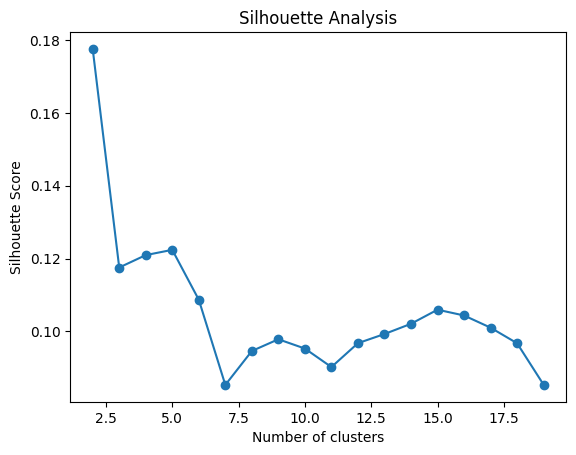

In [8]:
sil_scores = []
K_range = range(2, 20)

for k in K_range:
    model = AgglomerativeClustering(n_clusters=k).fit(features_scaled)
    labels = model.fit_predict(features_scaled)
    sil = silhouette_score(features_scaled, labels)
    sil_scores.append(sil)

plt.plot(K_range, sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()


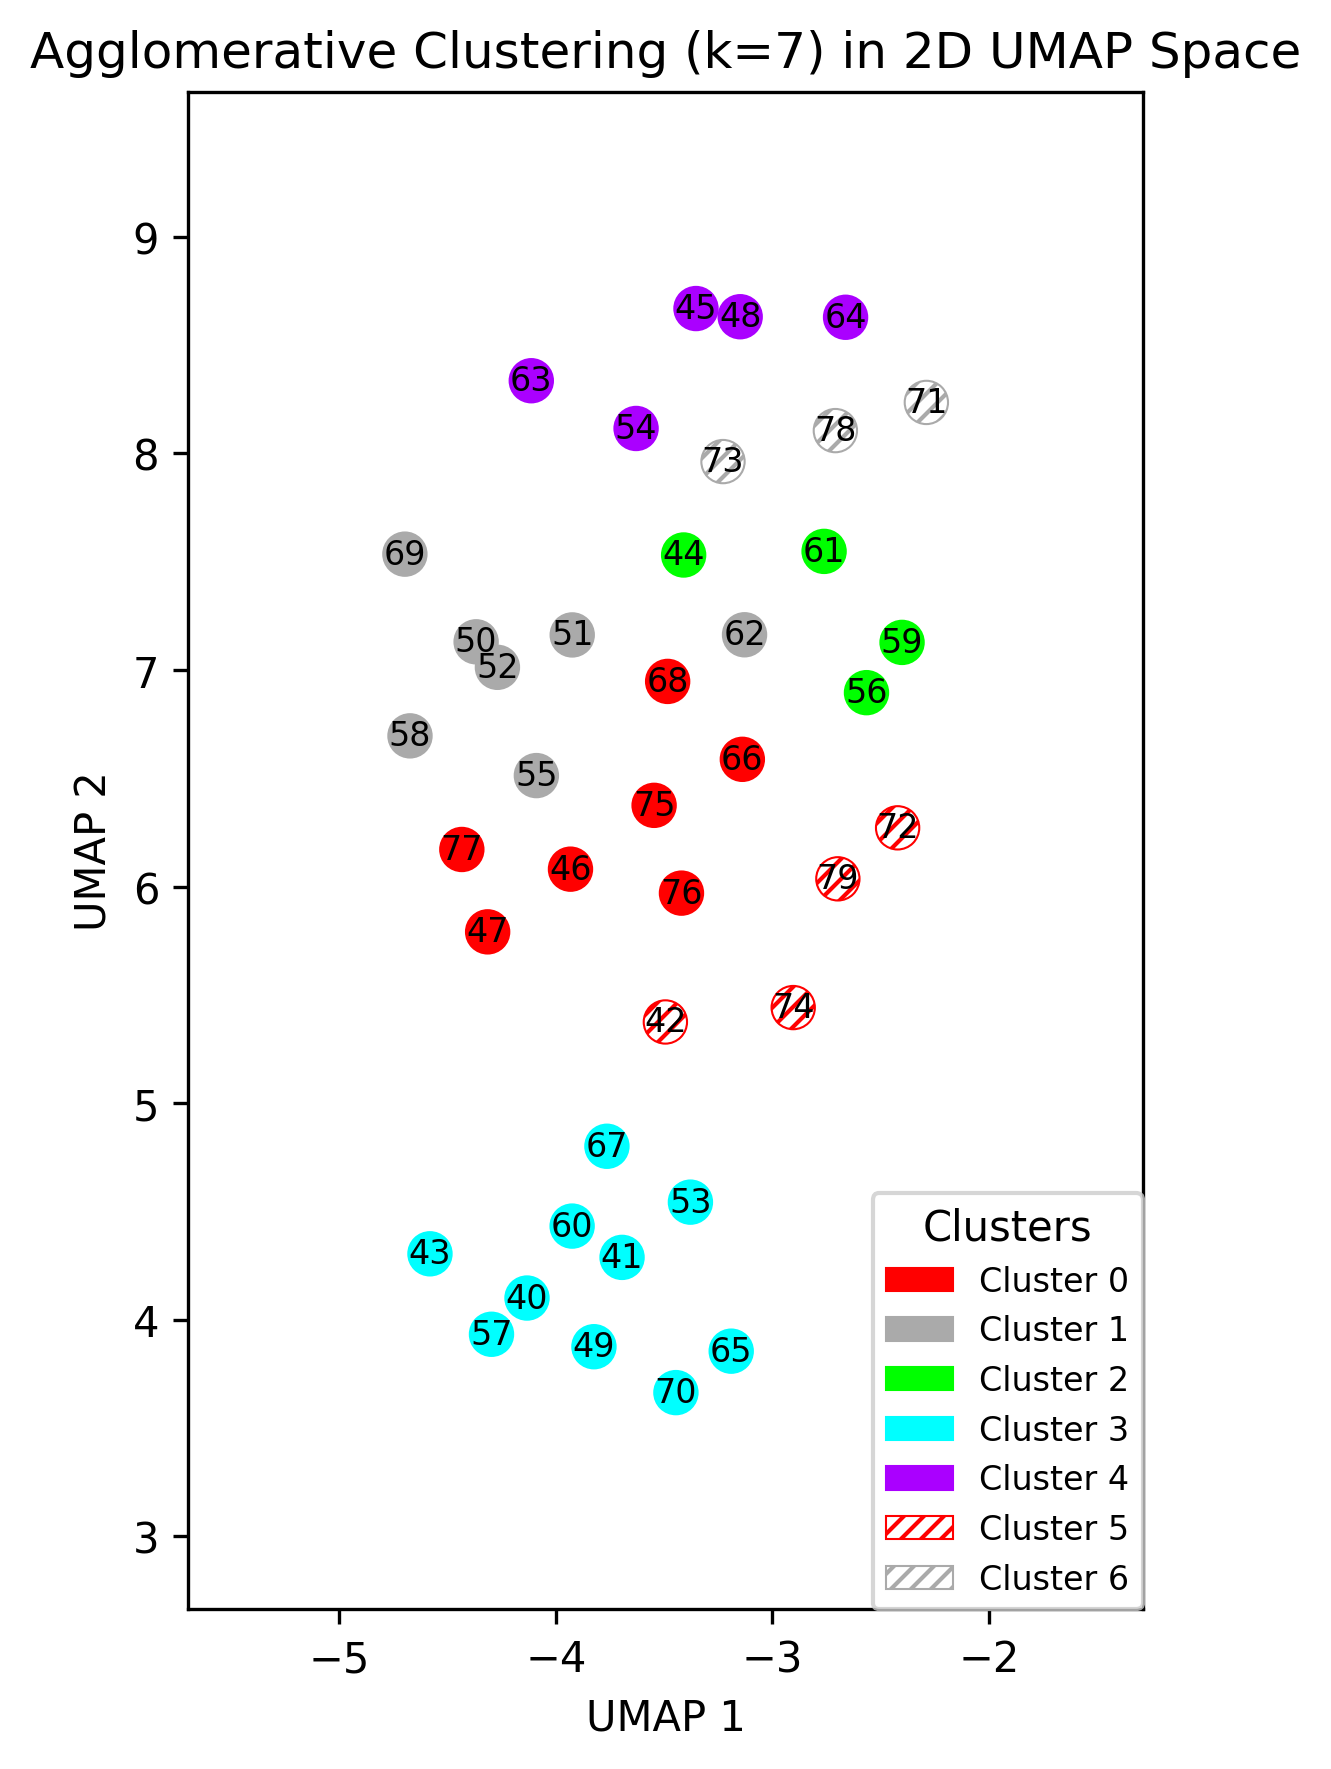

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
import umap
from sklearn.cluster import AgglomerativeClustering
from matplotlib.patches import Patch


# Step 1: Reduce dimensions for clustering
umap_reducer = umap.UMAP(n_components=10, random_state=0)
features_reduced = umap_reducer.fit_transform(features_scaled)

# Step 2: Perform clustering
final_k = 7
model = AgglomerativeClustering(n_clusters=final_k)
labels = model.fit_predict(features_reduced)

# Step 3: UMAP again for 2D visualization
umap_2d = umap.UMAP(n_components=2, random_state=0)
X_2d = umap_2d.fit_transform(features_scaled)

# Base 5-color palette (RYGCB)
base_colors = ['#FF0000', '#AAAAAA', '#00FF00', '#00FFFF', '#AA00FF']
fill_styles = ['solid', 'hatch1', 'hatch2']
hatch_patterns = {'solid': None,
                  'hatch1': '/////',
                  'hatch2': 'xxxx'}

# Define plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Plot each point with pattern + color
for i in range(len(X_2d)):
    label = labels[i]
    color = base_colors[label % 5]
    fill_style = fill_styles[label // 5]
    hatch = hatch_patterns[fill_style]

    x, y = X_2d[i]
    circle = Circle((x, y), radius=0.1,
                    facecolor=color if hatch is None else 'white',
                    edgecolor=color,
                    hatch=hatch,
                    linewidth=.5,
                    alpha=1)
    ax.add_patch(circle)

    video_id = agg_features.index[i]
    ax.text(x, y, str(video_id), fontsize=8, ha='center', va='center', color='black')

# Axis settings
ax.set_title(f'Agglomerative Clustering (k={final_k}) in 2D UMAP Space')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_xlim(X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1)
ax.set_ylim(X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1)
ax.set_aspect('equal')

# Legend setup
legend_elements = []
for label in np.unique(labels):
    color = base_colors[label % 5]
    fill_style = fill_styles[label // 5]
    hatch = hatch_patterns[fill_style]

    legend_elements.append(Patch(
        facecolor=color if hatch is None else 'white',
        edgecolor=color,
        hatch=hatch,
        label=f'Cluster {label}',
        linewidth=0.5
    ))

legend = ax.legend(
    handles=legend_elements,
    title='Clusters',
    # bbox_to_anchor=(1.01, 1),
    fontsize=8,
    loc='lower right',
    borderaxespad=0.,
    handletextpad=0.8
)

# Set all legend text to black for consistency
for text in legend.get_texts():
    text.set_color('black')

plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Start with a DataFrame that includes video numbers and their assigned clusters
video_cluster_df = pd.DataFrame({
    'video_number': agg_features.index,
    'cluster': labels
})

# Stratified split by cluster
train_videos, test_videos = train_test_split(
    video_cluster_df,
    test_size=0.2,
    stratify=video_cluster_df['cluster'],
    random_state=0
)
train_video_ids = train_videos['video_number'].values
test_video_ids = test_videos['video_number'].values

In [11]:
print("Training video IDs:", train_video_ids)
print("Testing video IDs:", test_video_ids)
print("Number of training videos:", len(train_video_ids))
print("Number of testing videos", len(test_video_ids))
print("Train/Test ratio:", 100*len(train_video_ids) / (len(train_video_ids)+len(test_video_ids)), ":", 100*len(test_video_ids) / (len(train_video_ids)+len(test_video_ids)))

Training video IDs: [53 72 64 48 43 73 67 65 59 69 51 56 46 68 57 40 47 52 78 58 54 55 66 77
 50 61 74 79 70 49 63 75]
Testing video IDs: [45 76 41 44 60 42 71 62]
Number of training videos: 32
Number of testing videos 8
Train/Test ratio: 80.0 : 20.0


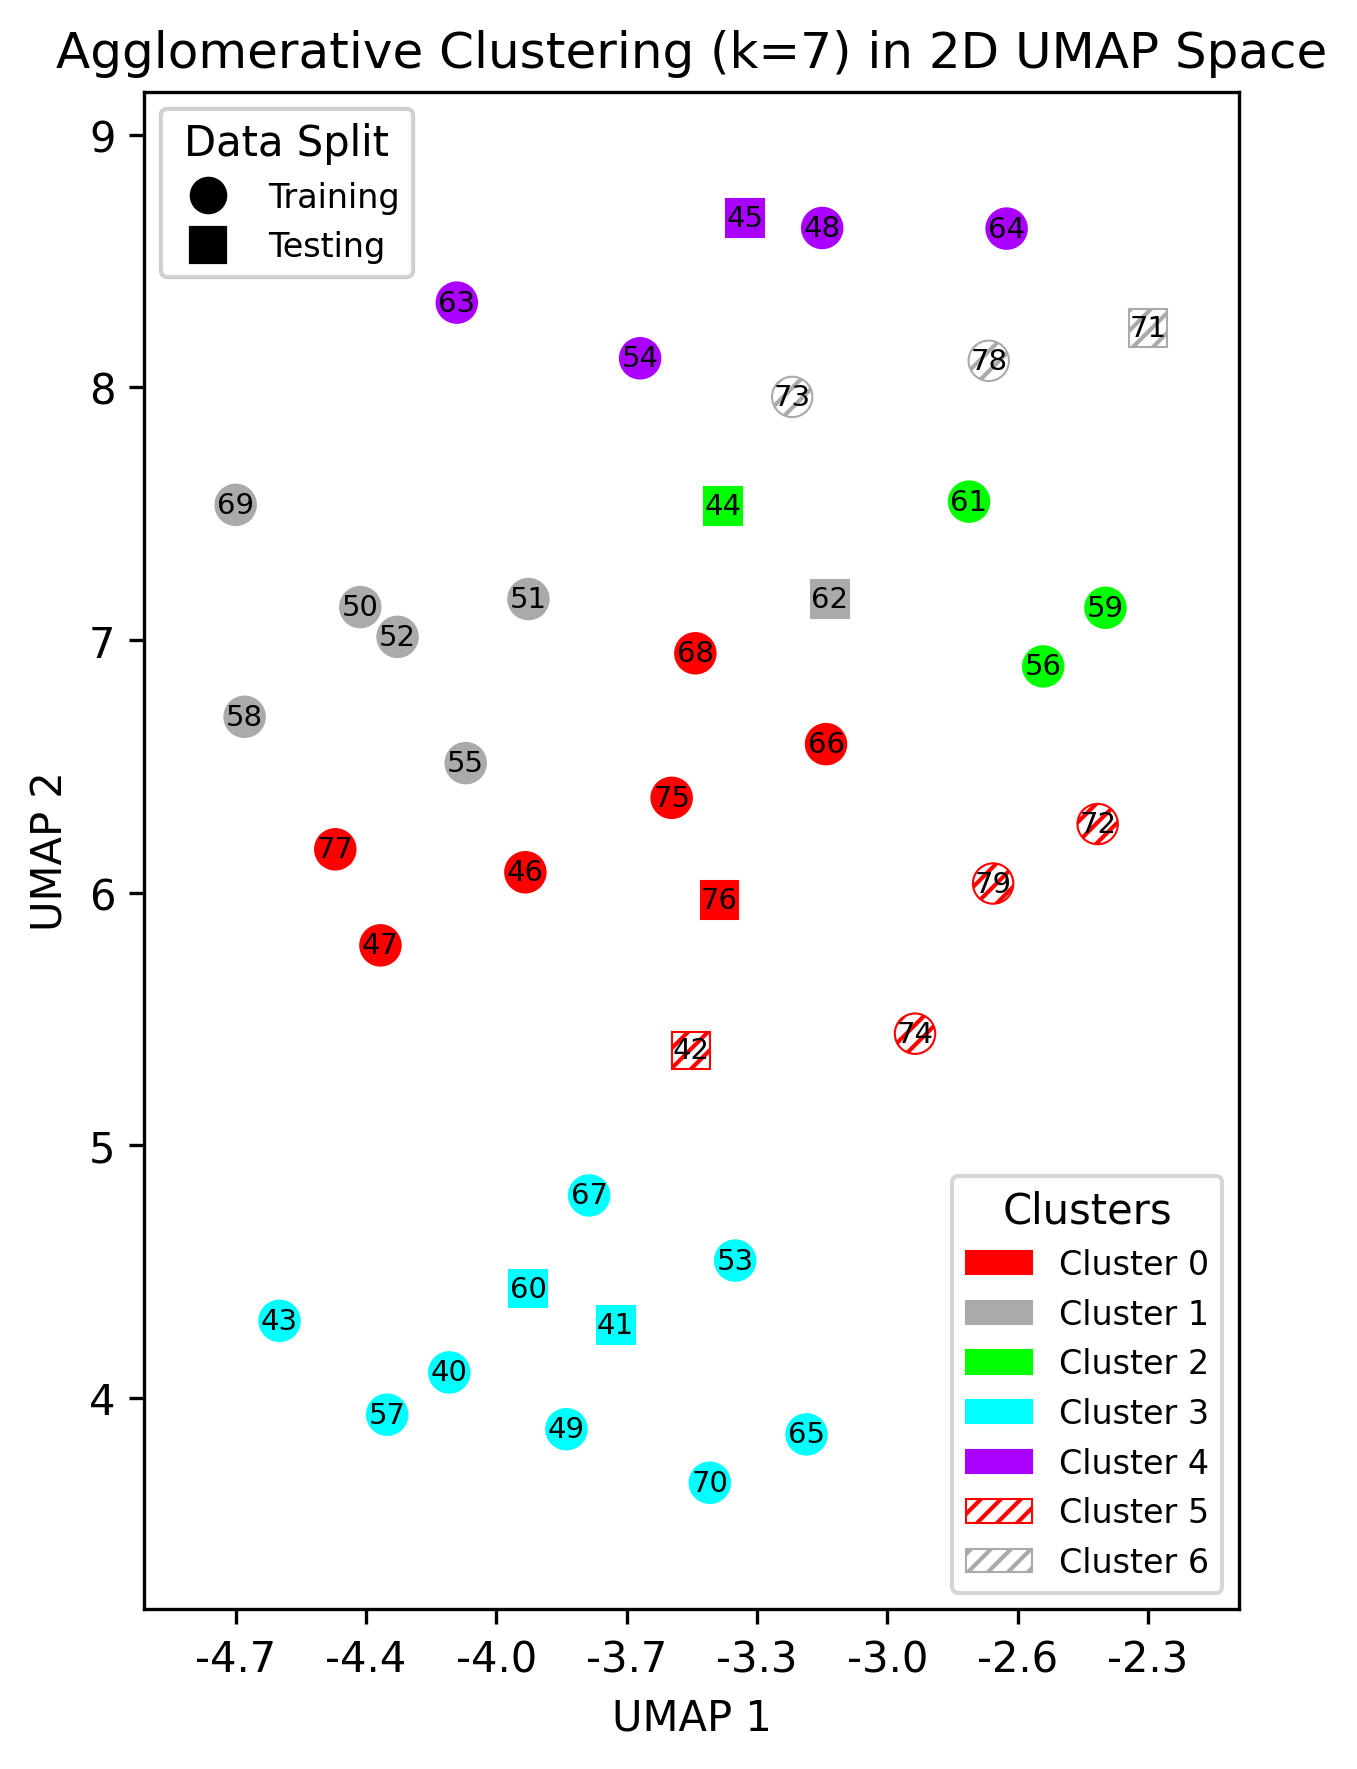

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Patch
from matplotlib.lines import Line2D
import numpy as np
import umap
from sklearn.cluster import AgglomerativeClustering

# UMAP dimensionality reduction
umap_2d = umap.UMAP(n_components=2, random_state=0)
X_2d = umap_2d.fit_transform(features_scaled)

# Stretch factor for X-axis (visual only)
x_stretch_factor = 1.5
X_plot = X_2d.copy()
X_plot[:, 0] *= x_stretch_factor  # Stretch only X values

# Cluster setup
final_k = 7
base_colors = ['#FF0000', '#AAAAAA', '#00FF00', '#00FFFF', '#AA00FF']
fill_styles = ['solid', 'hatch1', 'hatch2']
hatch_patterns = {'solid': None, 'hatch1': '/////', 'hatch2': 'xxxx'}

# Cluster model
model = AgglomerativeClustering(n_clusters=final_k)
labels = model.fit_predict(features_reduced)

# Masks
is_train = agg_features.index.isin(train_video_ids)

# Plot setup
fig, ax = plt.subplots(figsize=(20, 6), dpi=300)

label_offsets = {
}

for i in range(len(X_plot)):
    label = labels[i]
    color = base_colors[label % 5]
    fill_style = fill_styles[label // 5]
    hatch = hatch_patterns[fill_style]
    x, y = X_plot[i]

    if agg_features.index[i] in train_video_ids:
        marker = Circle((x, y), radius=0.08,
                        facecolor=color if hatch is None else 'white',
                        edgecolor=color, hatch=hatch,
                        linewidth=0.5, alpha=1)
    else:
        size = 0.15
        marker = Rectangle((x - size / 2, y - size / 2), width=size, height=size,
                           facecolor=color if hatch is None else 'white',
                           edgecolor=color, hatch=hatch,
                           linewidth=0.5, alpha=1)
    ax.add_patch(marker)

    video_id = agg_features.index[i]
    dx, dy = label_offsets.get(video_id, (0.0, 0.0))
    ax.text(x + dx, y + dy, str(video_id), fontsize=7, ha='center', va='center', color='black')

# Axes labels and title
ax.set_title(f'Agglomerative Clustering (k={final_k}) in 2D UMAP Space')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

# Axis limits (on stretched x-axis)
x_vals = X_plot[:, 0]
y_vals = X_plot[:, 1]
x_margin = (x_vals.max() - x_vals.min()) * 0.1
y_margin = (y_vals.max() - y_vals.min()) * 0.1
ax.set_xlim(x_vals.min() - x_margin, x_vals.max() + x_margin)
ax.set_ylim(y_vals.min() - y_margin, y_vals.max() + y_margin)

# Equal aspect, to keep shapes undistorted
ax.set_aspect('equal', adjustable='box')

# Custom tick labels to show original (unscaled) X values
xticks = np.linspace(x_vals.min(), x_vals.max(), num=8)
xticklabels = [f"{x / x_stretch_factor:.1f}" for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# --- Legend 1: Cluster Colors & Patterns ---
legend_elements = []
for label in np.unique(labels):
    color = base_colors[label % 5]
    fill_style = fill_styles[label // 5]
    hatch = hatch_patterns[fill_style]
    legend_elements.append(Patch(
        facecolor=color if hatch is None else 'white',
        edgecolor=color,
        hatch=hatch,
        label=f'Cluster {label}',
        linewidth=0.5
    ))

legend1 = ax.legend(
    handles=legend_elements,
    title='Clusters',
    fontsize=8,
    loc='lower right',
    frameon=True
)
ax.add_artist(legend1)

# --- Legend 2: Data Split (Train/Test) ---
marker_handles = [
    Line2D([0], [0], marker='o', color='black', label='Training',
           markersize=8, linestyle='None'),
    Line2D([0], [0], marker='s', color='black', label='Testing',
           markersize=8, linestyle='None')
]
legend2 = ax.legend(
    handles=marker_handles,
    title='Data Split',
    fontsize=8,
    loc='upper left',
    frameon=True
)
ax.add_artist(legend2)

plt.tight_layout()
plt.show()


In [13]:
df_split = video_cluster_df.copy()

# Add 'split' column based on train/test membership
df_split['split'] = df_split['video_number'].apply(
    lambda x: 'train' if x in train_video_ids else 'test'
)
df_split['video_number'] = df_split['video_number'].apply(lambda x: f'{x:03d}_30s')

df_split.to_csv('30s_video_splits.csv', index=False)
